In [1]:
# This has nu = 0.01; as opposed to 0.005
# This uses parallel trajectories; adds more noise (std = 0.1)

# basic libraries
import numpy as np
import tensorflow as tf
import tensorflow.keras.backend as K
import mhd_numerical_diff2 as mhdmod
import traj_utilities as tju
import matplotlib.pyplot as plt
import h5py as h5

In [2]:
#trained model weights
model_brio = mhdmod.MHD_nd(gamma=2.,nh=48, nlayers=4, model_name='dummy',do_visc=True,visc=0.01, dx=0.001, dt=0.001)
model_brio.load_weights("./brio/4_traj_para_wnoise1/best_weights/weights")

In [3]:
# read in spacetime data
fname = '../brio_wu_space/briowu_ST.h5'
space,time,sc_1,sc_2,sc_3,sc_4,st_data,st_input, data_input = tju.load_sp_mhd_data(fname, 'briowu', parallel=True)

In [4]:
data_input_noise = tju.add_noise(data_input, std=0.1)

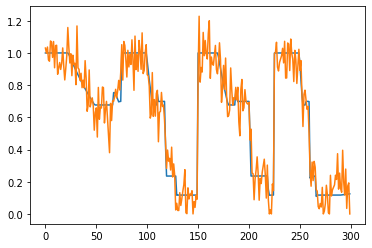

In [5]:
fig,ax = plt.subplots()

ax.plot(data_input[:,0])
ax.plot(data_input_noise[:,0])

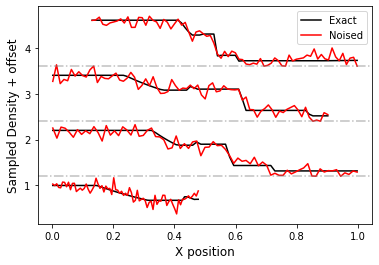

In [6]:
fig, ax = plt.subplots()
i=0
ax.plot(sc_1[:,0],1.2*i+data_input[75*i:75*(i+1),0],color='black',label='Exact')
ax.plot(sc_1[:,0],1.2*i+data_input_noise[75*i:75*(i+1),0],color='red',label='Noised')
for i,sc in zip(range(1,4),[sc_2,sc_3,sc_4]):
    ax.plot(sc[:,0],1.2*i+data_input[75*i:75*(i+1),0],color='black')
    ax.plot(sc[:,0],1.2*i+data_input_noise[75*i:75*(i+1),0], color='red')

ax.axhline(1.2,color='grey',alpha=0.5,ls='-.')
ax.axhline(1.2*2,color='grey',alpha=0.5,ls='-.')
ax.axhline(1.2*3,color='grey',alpha=0.5,ls='-.')

ax.set_xlabel('X position', fontsize=12)
ax.set_ylabel("Sampled Density + offset",fontsize=12)
ax.legend()
fig.savefig('brio_traj_noise.jpg',dpi=300)

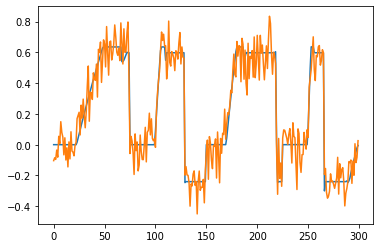

In [7]:
fig,ax = plt.subplots()
ax.plot(data_input[:,1])
ax.plot(data_input_noise[:,1])

In [8]:
# define grid(s) for reproducing results

# for comparison with full simulation
xx,tt = np.meshgrid(space,time,indexing='ij')
xxtt = np.stack((xx.flatten(), tt.flatten())).T #returns (Np, 2) for input into PINN

nx = len(space)
nt = len(time)

#lower res grid
nx_samp = 101
nt_samp = 101
sptim_lin = mhdmod.generate_spacetime_coloc_linear([[space[0],space[-1]]],[time[0],time[-1]],nx_samp,nt_samp).numpy()

In [9]:
#generate predictions
pred_brio = model_brio(xxtt)
pred_rho = pred_brio[:,0].numpy().reshape(nx,nt)
pred_vx = pred_brio[:,1].numpy().reshape(nx,nt)
pred_vy = pred_brio[:,2].numpy().reshape(nx,nt)
pred_p = pred_brio[:,4].numpy().reshape(nx,nt)
pred_by = pred_brio[:,6].numpy().reshape(nx,nt)

pred_brio_lin = model_brio(sptim_lin)
pred_rho_lin = pred_brio_lin[:,0].numpy().reshape(nx_samp,nt_samp)
pred_vx_lin = pred_brio_lin[:,1].numpy().reshape(nx_samp,nt_samp)
pred_vy_lin = pred_brio_lin[:,2].numpy().reshape(nx_samp,nt_samp)
pred_p_lin = pred_brio_lin[:,4].numpy().reshape(nx_samp,nt_samp)
pred_by_lin = pred_brio_lin[:,6].numpy().reshape(nx_samp,nt_samp)

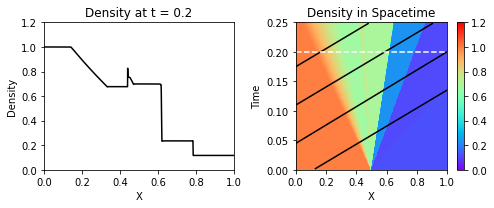

In [10]:
# plots
fig = plt.figure()
ax = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
fig.set_size_inches(7,3)

ax.plot(space,st_data[0,:,100],color='k') # 100 is t = 0.2
ax.set_xlim(0.,1.)
ax.set_ylim(0.,1.2)
ax.set_xlabel("X")
ax.set_ylabel("Density")
ax.set_title("Density at t = 0.2")

img = ax2.pcolormesh(space,time,st_data[0].T, cmap=plt.cm.rainbow,vmin=0., vmax=1.2, shading='auto')
ax2.set_xlim(0.,1.)
ax2.set_ylim(0.,0.25)
ax2.set_xlabel("X")
ax2.set_ylabel("Time")
ax2.set_title("Density in Spacetime")
ax2.plot(sc_1[:,0], sc_1[:,1],color='k')
ax2.plot(sc_2[:,0], sc_2[:,1],color='k')
ax2.plot(sc_3[:,0], sc_3[:,1],color='k')
ax2.plot(sc_4[:,0], sc_4[:,1],color='k')
ax2.axhline(0.2,0,1,color='white',ls='--',lw=1.5)

fig.colorbar(img)
plt.tight_layout()
#fig.savefig("brio_density_example.png", dpi=400)

In [11]:
error_rho_rel = np.abs((pred_rho - st_data[0])/st_data[0])
error_vx_rel = np.abs((pred_vx - st_data[1])/pred_vx)
error_vy_rel = np.abs((pred_vy - st_data[2])/pred_vy)
error_p_rel = np.abs((pred_p - st_data[4])/st_data[4])
error_by_rel = np.abs((pred_by - st_data[6])/pred_by)

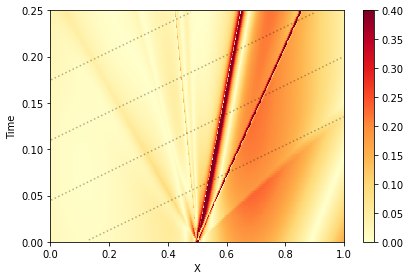

In [12]:
# error comparison
fig = plt.figure()
ax = fig.add_subplot(111)

#This figure is a plot of the relative error of density
img = ax.pcolormesh(space,time,error_rho_rel.T, cmap=plt.cm.YlOrRd,vmin=0., vmax=0.4, shading='auto')
ax.plot(sc_1[:,0], sc_1[:,1],color='k', ls=':',alpha=0.3)
ax.plot(sc_2[:,0], sc_2[:,1],color='k', ls=':',alpha=0.3)
ax.plot(sc_3[:,0], sc_3[:,1],color='k', ls=':',alpha=0.3)
ax.plot(sc_4[:,0], sc_4[:,1],color='k', ls=':',alpha=0.3)
ax.set_xlim(0.,1.)
ax.set_ylim(0.,0.25)
ax.set_xlabel("X")
ax.set_ylabel("Time")

fig.colorbar(img)
plt.tight_layout()
#fig.savefig("Sod_rel_error_compare.png", dpi=400)

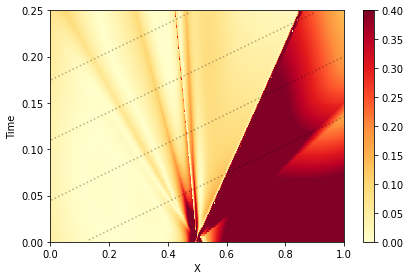

In [13]:
fig = plt.figure()
ax = fig.add_subplot(111)

#This figure is a plot of the relative error of pressure

img = ax.pcolormesh(space,time,error_p_rel.T, cmap=plt.cm.YlOrRd,vmin=0., vmax=0.4, shading='auto')
ax.plot(sc_1[:,0], sc_1[:,1],color='k', ls=':',alpha=0.3)
ax.plot(sc_2[:,0], sc_2[:,1],color='k', ls=':',alpha=0.3)
ax.plot(sc_3[:,0], sc_3[:,1],color='k', ls=':',alpha=0.3)
ax.plot(sc_4[:,0], sc_4[:,1],color='k', ls=':',alpha=0.3)
ax.set_xlim(0.,1.)
ax.set_ylim(0.,0.25)
ax.set_xlabel("X")
ax.set_ylabel("Time")

fig.colorbar(img)
plt.tight_layout()

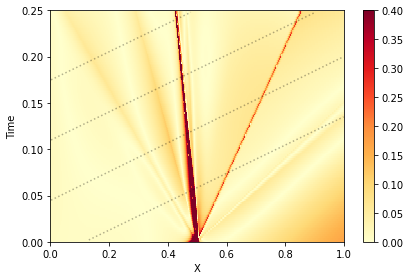

In [14]:
fig = plt.figure()
ax = fig.add_subplot(111)

#This figure is a plot of the relative error of By
# jankiness due to By = 0 on rhs of figure

img = ax.pcolormesh(space,time,error_by_rel.T, cmap=plt.cm.YlOrRd,vmin=0., vmax=0.4, shading='auto')
ax.plot(sc_1[:,0], sc_1[:,1],color='k', ls=':',alpha=0.3)
ax.plot(sc_2[:,0], sc_2[:,1],color='k', ls=':',alpha=0.3)
ax.plot(sc_3[:,0], sc_3[:,1],color='k', ls=':',alpha=0.3)
ax.plot(sc_4[:,0], sc_4[:,1],color='k', ls=':',alpha=0.3)
ax.set_xlim(0.,1.)
ax.set_ylim(0.,0.25)
ax.set_xlabel("X")
ax.set_ylabel("Time")

fig.colorbar(img)
plt.tight_layout()

In [15]:
error_rho_abs = np.abs((pred_rho - st_data[0]))
error_vx_abs = np.abs((pred_vx - st_data[1]))
error_vy_abs = np.abs((pred_vy - st_data[2]))
error_p_abs = np.abs((pred_p - st_data[4]))
error_by_abs = np.abs((pred_by - st_data[6]))

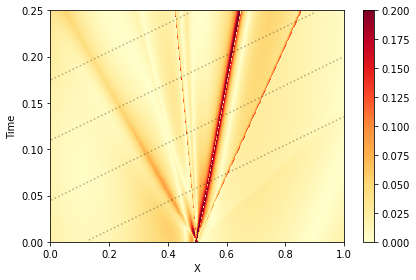

In [16]:
fig = plt.figure()
ax = fig.add_subplot(111)

#This figure is a plot of the absolute error of density
img = ax.pcolormesh(space,time,error_rho_abs.T, cmap=plt.cm.YlOrRd,vmin=0., vmax=0.2, shading='auto')
ax.plot(sc_1[:,0], sc_1[:,1],color='k', ls=':',alpha=0.3)
ax.plot(sc_2[:,0], sc_2[:,1],color='k', ls=':',alpha=0.3)
ax.plot(sc_3[:,0], sc_3[:,1],color='k', ls=':',alpha=0.3)
ax.plot(sc_4[:,0], sc_4[:,1],color='k', ls=':',alpha=0.3)
ax.set_xlim(0.,1.)
ax.set_ylim(0.,0.25)
ax.set_xlabel("X")
ax.set_ylabel("Time")

fig.colorbar(img)
plt.tight_layout()

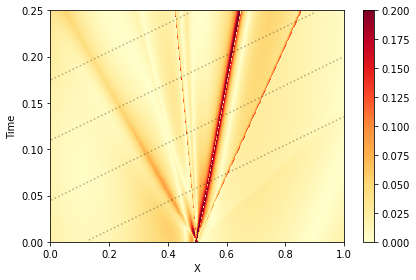

In [17]:
fig = plt.figure()
ax = fig.add_subplot(111)

#This figure is a plot of the absolute error of pressure
img = ax.pcolormesh(space,time,error_rho_abs.T, cmap=plt.cm.YlOrRd,vmin=0., vmax=0.2, shading='auto')
ax.plot(sc_1[:,0], sc_1[:,1],color='k', ls=':',alpha=0.3)
ax.plot(sc_2[:,0], sc_2[:,1],color='k', ls=':',alpha=0.3)
ax.plot(sc_3[:,0], sc_3[:,1],color='k', ls=':',alpha=0.3)
ax.plot(sc_4[:,0], sc_4[:,1],color='k', ls=':',alpha=0.3)
ax.set_xlim(0.,1.)
ax.set_ylim(0.,0.25)
ax.set_xlabel("X")
ax.set_ylabel("Time")

fig.colorbar(img)
plt.tight_layout()

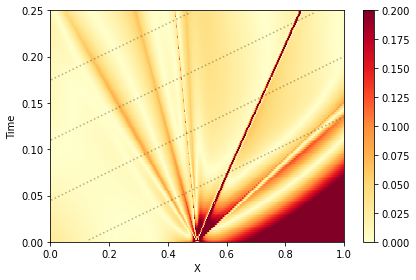

In [18]:
fig = plt.figure()
ax = fig.add_subplot(111)

#This figure is a plot of the absolute error of vx
img = ax.pcolormesh(space,time,error_vx_abs.T, cmap=plt.cm.YlOrRd,vmin=0., vmax=0.2, shading='auto')
ax.plot(sc_1[:,0], sc_1[:,1],color='k', ls=':',alpha=0.3)
ax.plot(sc_2[:,0], sc_2[:,1],color='k', ls=':',alpha=0.3)
ax.plot(sc_3[:,0], sc_3[:,1],color='k', ls=':',alpha=0.3)
ax.plot(sc_4[:,0], sc_4[:,1],color='k', ls=':',alpha=0.3)
ax.set_xlim(0.,1.)
ax.set_ylim(0.,0.25)
ax.set_xlabel("X")
ax.set_ylabel("Time")

fig.colorbar(img)
plt.tight_layout()

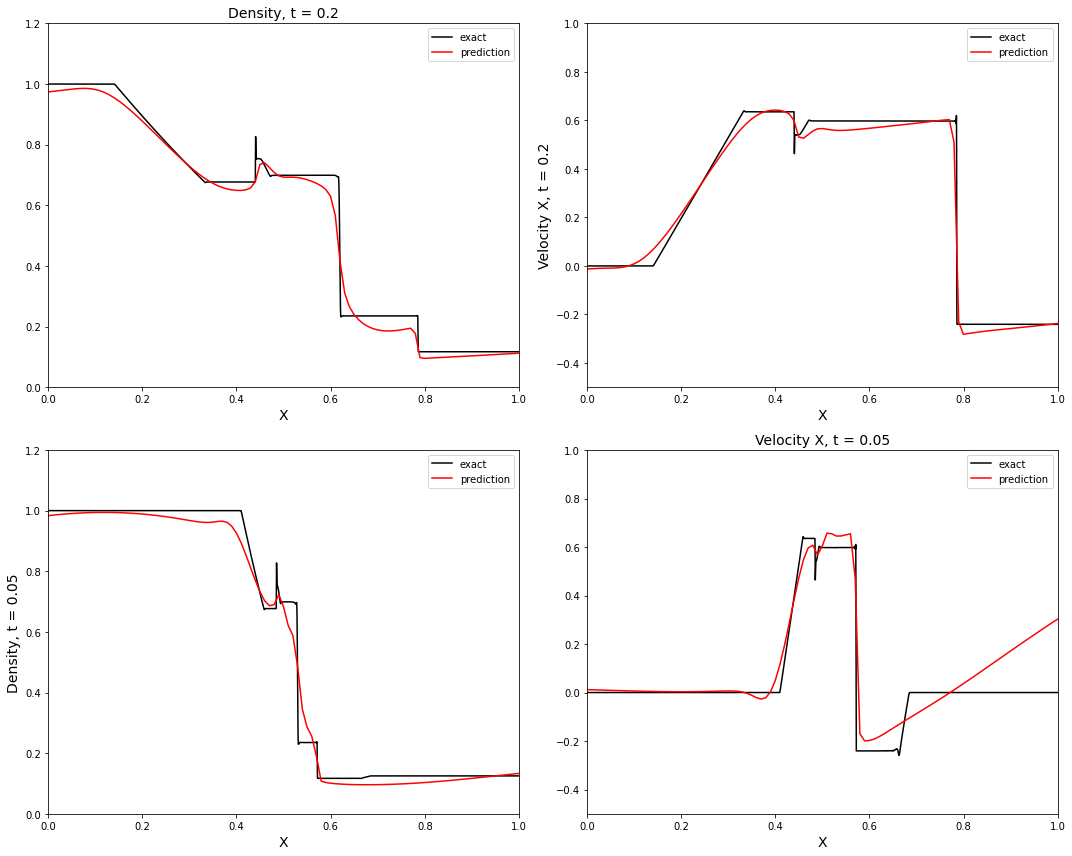

In [19]:
fig = plt.figure()
ax = fig.add_subplot(221)

ax.plot(space,st_data[0,:,100],color='k',label="exact")
i = np.where(sptim_lin[::nt_samp,1] >= 0.2)[0][0]
ax.plot(sptim_lin[:nx_samp,0], pred_brio_lin[101*i:(i+1)*101,0],color='r', label='prediction')
ax.legend(loc='best')
ax.set_xlim(0,1)
ax.set_ylim(0,1.2)
ax.set_xlabel("X",fontsize=14)
ax.set_title("Density, t = 0.2",fontsize=14)

ax2 = fig.add_subplot(222)
ax2.plot(space,st_data[1,:,100],color='k',label="exact")
ax2.plot(sptim_lin[:nx_samp,0], pred_brio_lin[101*i:(i+1)*101,1],color='r', label='prediction')
ax2.legend(loc='best')
ax2.set_xlim(0,1)
ax2.set_ylim(-0.5,1.)
ax2.set_xlabel("X",fontsize=14)
ax2.set_ylabel("Velocity X, t = 0.2",fontsize=14)

ax3 = fig.add_subplot(223)
j = np.where(sptim_lin[::nt_samp,1] >= 0.05)[0][0]
ax3.plot(space,st_data[0,:,25],color='k',label="exact")
ax3.plot(sptim_lin[:nx_samp,0], pred_brio_lin[101*j:(j+1)*101,0],color='r', label='prediction')
ax3.legend(loc='best')
ax3.set_xlim(0,1)
ax3.set_ylim(0.,1.2)
ax3.set_xlabel("X",fontsize=14)
ax3.set_ylabel("Density, t = 0.05",fontsize=14)

ax4 = fig.add_subplot(224)
ax4.plot(space,st_data[1,:,25],color='k',label="exact")
ax4.plot(sptim_lin[:nx_samp,0], pred_brio_lin[101*j:(j+1)*101,1],color='r', label='prediction')
ax4.legend(loc='best')
ax4.set_xlim(0,1)
ax4.set_ylim(-0.5,1.)
ax4.set_xlabel("X",fontsize=14)
ax4.set_title("Velocity X, t = 0.05",fontsize=14)


fig.set_size_inches(15,12)
plt.tight_layout()

In [20]:
sptim_lin = mhdmod.generate_spacetime_coloc_linear([[space[0],space[-1]]],[time[0],time[-1]],nx_samp,nt_samp).numpy()

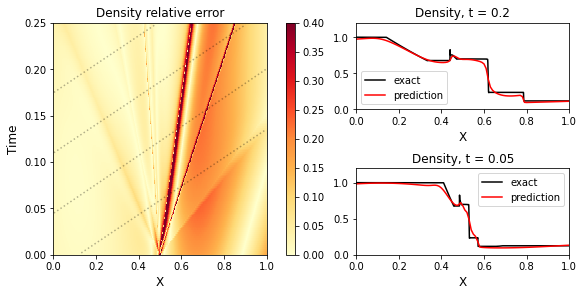

In [21]:
fig = plt.Figure(constrained_layout=True)
mosaic = """
AABB
AACC
"""
axd = fig.subplot_mosaic(mosaic)
img = axd['A'].pcolormesh(space,time,error_rho_rel.T, cmap=plt.cm.YlOrRd,vmin=0., vmax=0.4, shading='auto')
axd['A'].plot(sc_1[:,0], sc_1[:,1],color='k', ls=':',alpha=0.3)
axd['A'].plot(sc_2[:,0], sc_2[:,1],color='k', ls=':',alpha=0.3)
axd['A'].plot(sc_3[:,0], sc_3[:,1],color='k', ls=':',alpha=0.3)
axd['A'].plot(sc_4[:,0], sc_4[:,1],color='k', ls=':',alpha=0.3)
axd['A'].set_xlim(0.,1.)
axd['A'].set_ylim(0.,0.25)
axd['A'].set_xlabel("X",fontsize=12)
axd['A'].set_ylabel("Time",fontsize=12)
axd['A'].set_title("Density relative error", fontsize=12)

axd['B'].plot(space,st_data[0,:,100],color='k',label="exact")
i = np.where(sptim_lin[::nt_samp,1] >= 0.2)[0][0]
axd['B'].plot(sptim_lin[:nx_samp,0], pred_brio_lin[101*i:(i+1)*101,0],color='r', label='prediction')
axd['B'].legend(loc='best')
axd['B'].set_xlim(0,1)
axd['B'].set_ylim(0,1.2)
axd['B'].set_xlabel("X",fontsize=12)
axd['B'].set_title("Density, t = 0.2",fontsize=12)

axd['C'].plot(space,st_data[0,:,25],color='k',label="exact")
i = np.where(sptim_lin[::nt_samp,1] >= 0.05)[0][0]
axd['C'].plot(sptim_lin[:nx_samp,0], pred_brio_lin[101*i:(i+1)*101,0],color='r', label='prediction')
axd['C'].legend(loc='best')
axd['C'].set_xlim(0,1)
axd['C'].set_ylim(0,1.2)
axd['C'].set_xlabel("X",fontsize=12)
axd['C'].set_title("Density, t = 0.05",fontsize=12)
fig.set_size_inches(8,4)
fig.colorbar(img, location='right',ax=axd['A'],fraction=0.01, aspect=50)
fig.savefig("brio_mosaicvisc01_para_noise_1.png", dpi=300,facecolor='white',transparent=False)
fig

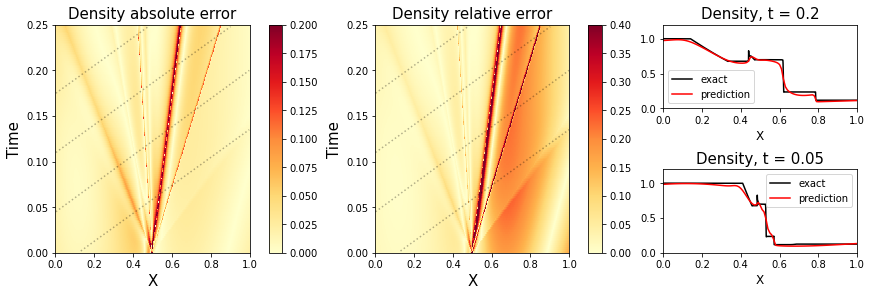

In [22]:
fig = plt.Figure(constrained_layout=True)
mosaic = """
DDAABB
DDAACC
"""
axd = fig.subplot_mosaic(mosaic)
img = axd['A'].pcolormesh(space,time,error_rho_rel.T, cmap=plt.cm.YlOrRd,vmin=0., vmax=0.4, shading='auto')
axd['A'].plot(sc_1[:,0], sc_1[:,1],color='k', ls=':',alpha=0.3)
axd['A'].plot(sc_2[:,0], sc_2[:,1],color='k', ls=':',alpha=0.3)
axd['A'].plot(sc_3[:,0], sc_3[:,1],color='k', ls=':',alpha=0.3)
axd['A'].plot(sc_4[:,0], sc_4[:,1],color='k', ls=':',alpha=0.3)
axd['A'].set_xlim(0.,1.)
axd['A'].set_ylim(0.,0.25)
axd['A'].set_xlabel("X",fontsize=15)
axd['A'].set_ylabel("Time",fontsize=15)
axd['A'].set_title("Density relative error", fontsize=15)

axd['B'].plot(space,st_data[0,:,100],color='k',label="exact")
i = np.where(sptim_lin[::nt_samp,1] >= 0.2)[0][0]
axd['B'].plot(sptim_lin[:nx_samp,0], pred_brio_lin[101*i:(i+1)*101,0],color='r', label='prediction')
axd['B'].legend(loc='best')
axd['B'].set_xlim(0,1)
axd['B'].set_ylim(0,1.2)
axd['B'].set_xlabel("X",fontsize=12)
axd['B'].set_title("Density, t = 0.2",fontsize=15)

axd['C'].plot(space,st_data[0,:,25],color='k',label="exact")
i = np.where(sptim_lin[::nt_samp,1] >= 0.05)[0][0]
axd['C'].plot(sptim_lin[:nx_samp,0], pred_brio_lin[101*i:(i+1)*101,0],color='r', label='prediction')
axd['C'].legend(loc='best')
axd['C'].set_xlim(0,1)
axd['C'].set_ylim(0,1.2)
axd['C'].set_xlabel("X",fontsize=12)
axd['C'].set_title("Density, t = 0.05",fontsize=15)

img2 = axd['D'].pcolormesh(space,time,error_rho_abs.T, cmap=plt.cm.YlOrRd,vmin=0., vmax=0.2, shading='auto')
axd['D'].plot(sc_1[:,0], sc_1[:,1],color='k', ls=':',alpha=0.3)
axd['D'].plot(sc_2[:,0], sc_2[:,1],color='k', ls=':',alpha=0.3)
axd['D'].plot(sc_3[:,0], sc_3[:,1],color='k', ls=':',alpha=0.3)
axd['D'].plot(sc_4[:,0], sc_4[:,1],color='k', ls=':',alpha=0.3)
axd['D'].set_xlim(0.,1.)
axd['D'].set_ylim(0.,0.25)
axd['D'].set_xlabel("X",fontsize=15)
axd['D'].set_ylabel("Time",fontsize=15)
axd['D'].set_title("Density absolute error", fontsize=15)

fig.set_size_inches(12,4)
fig.colorbar(img, location='right',ax=axd['A'],fraction=0.01, aspect=50)
fig.colorbar(img2, location='right',ax=axd['D'],fraction=0.01, aspect=50)
#fig.savefig("brio_mosaicvisc01_para_relabs.jpg", dpi=300)
fig

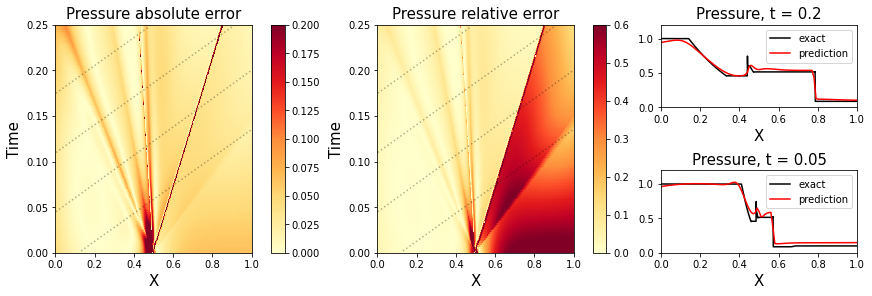

In [28]:
fig = plt.Figure(constrained_layout=True)
mosaic = """
DDAABB
DDAACC
"""
axd = fig.subplot_mosaic(mosaic)
img = axd['A'].pcolormesh(space,time,error_p_rel.T, cmap=plt.cm.YlOrRd,vmin=0., vmax=0.6, shading='auto')
axd['A'].plot(sc_1[:,0], sc_1[:,1],color='k', ls=':',alpha=0.3)
axd['A'].plot(sc_2[:,0], sc_2[:,1],color='k', ls=':',alpha=0.3)
axd['A'].plot(sc_3[:,0], sc_3[:,1],color='k', ls=':',alpha=0.3)
axd['A'].plot(sc_4[:,0], sc_4[:,1],color='k', ls=':',alpha=0.3)
axd['A'].set_xlim(0.,1.)
axd['A'].set_ylim(0.,0.25)
axd['A'].set_xlabel("X",fontsize=15)
axd['A'].set_ylabel("Time",fontsize=15)
axd['A'].set_title("Pressure relative error", fontsize=15)

axd['B'].plot(space,st_data[4,:,100],color='k',label="exact")
i = np.where(sptim_lin[::nt_samp,1] >= 0.2)[0][0]
axd['B'].plot(sptim_lin[:nx_samp,0], pred_brio_lin[101*i:(i+1)*101,4],color='r', label='prediction')
axd['B'].legend(loc='best')
axd['B'].set_xlim(0,1)
axd['B'].set_ylim(0,1.2)
axd['B'].set_xlabel("X",fontsize=15)
axd['B'].set_title("Pressure, t = 0.2",fontsize=15)

axd['C'].plot(space,st_data[4,:,25],color='k',label="exact")
i = np.where(sptim_lin[::nt_samp,1] >= 0.05)[0][0]
axd['C'].plot(sptim_lin[:nx_samp,0], pred_brio_lin[101*i:(i+1)*101,4],color='r', label='prediction')
axd['C'].legend(loc='best')
axd['C'].set_xlim(0,1)
axd['C'].set_ylim(0,1.2)
axd['C'].set_xlabel("X",fontsize=15)
axd['C'].set_title("Pressure, t = 0.05",fontsize=15)

img2 = axd['D'].pcolormesh(space,time,error_p_abs.T, cmap=plt.cm.YlOrRd,vmin=0., vmax=0.2, shading='auto')
axd['D'].plot(sc_1[:,0], sc_1[:,1],color='k', ls=':',alpha=0.3)
axd['D'].plot(sc_2[:,0], sc_2[:,1],color='k', ls=':',alpha=0.3)
axd['D'].plot(sc_3[:,0], sc_3[:,1],color='k', ls=':',alpha=0.3)
axd['D'].plot(sc_4[:,0], sc_4[:,1],color='k', ls=':',alpha=0.3)
axd['D'].set_xlim(0.,1.)
axd['D'].set_ylim(0.,0.25)
axd['D'].set_xlabel("X",fontsize=15)
axd['D'].set_ylabel("Time",fontsize=15)
axd['D'].set_title("Pressure absolute error", fontsize=15)

fig.set_size_inches(12,4)
fig.colorbar(img, location='right',ax=axd['A'],fraction=0.01, aspect=50)
fig.colorbar(img2, location='right',ax=axd['D'],fraction=0.01, aspect=50)
#fig.savefig("brio_mosaicvisc01_para_P_rel_abs.jpg", dpi=300)
fig

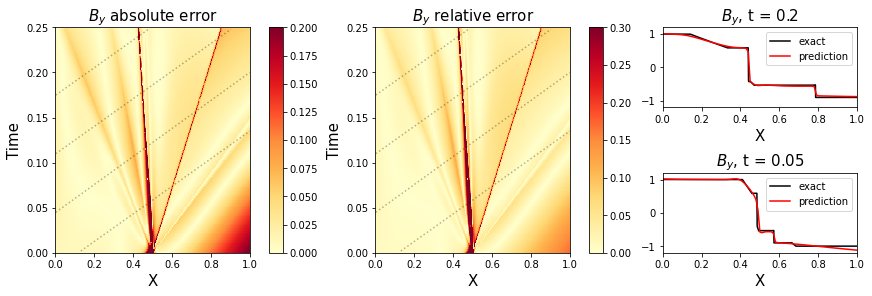

In [27]:
fig = plt.Figure(constrained_layout=True)
mosaic = """
DDAABB
DDAACC
"""
axd = fig.subplot_mosaic(mosaic)
img = axd['A'].pcolormesh(space,time,error_by_rel.T, cmap=plt.cm.YlOrRd,vmin=0., vmax=0.3, shading='auto')
axd['A'].plot(sc_1[:,0], sc_1[:,1],color='k', ls=':',alpha=0.3)
axd['A'].plot(sc_2[:,0], sc_2[:,1],color='k', ls=':',alpha=0.3)
axd['A'].plot(sc_3[:,0], sc_3[:,1],color='k', ls=':',alpha=0.3)
axd['A'].plot(sc_4[:,0], sc_4[:,1],color='k', ls=':',alpha=0.3)
axd['A'].set_xlim(0.,1.)
axd['A'].set_ylim(0.,0.25)
axd['A'].set_xlabel("X",fontsize=15)
axd['A'].set_ylabel("Time",fontsize=15)
axd['A'].set_title("$B_y$ relative error", fontsize=15)

axd['B'].plot(space,st_data[6,:,100],color='k',label="exact")
i = np.where(sptim_lin[::nt_samp,1] >= 0.2)[0][0]
axd['B'].plot(sptim_lin[:nx_samp,0], pred_brio_lin[101*i:(i+1)*101,6],color='r', label='prediction')
axd['B'].legend(loc='best')
axd['B'].set_xlim(0,1)
axd['B'].set_ylim(-1.2,1.2)
axd['B'].set_xlabel("X",fontsize=15)
axd['B'].set_title("$B_y$, t = 0.2",fontsize=15)

axd['C'].plot(space,st_data[6,:,25],color='k',label="exact")
i = np.where(sptim_lin[::nt_samp,1] >= 0.05)[0][0]
axd['C'].plot(sptim_lin[:nx_samp,0], pred_brio_lin[101*i:(i+1)*101,6],color='r', label='prediction')
axd['C'].legend(loc='best')
axd['C'].set_xlim(0,1)
axd['C'].set_ylim(-1.2,1.2)
axd['C'].set_xlabel("X",fontsize=15)
axd['C'].set_title("$B_y$, t = 0.05",fontsize=15)

img2 = axd['D'].pcolormesh(space,time,error_by_abs.T, cmap=plt.cm.YlOrRd,vmin=0., vmax=0.2, shading='auto')
axd['D'].plot(sc_1[:,0], sc_1[:,1],color='k', ls=':',alpha=0.3)
axd['D'].plot(sc_2[:,0], sc_2[:,1],color='k', ls=':',alpha=0.3)
axd['D'].plot(sc_3[:,0], sc_3[:,1],color='k', ls=':',alpha=0.3)
axd['D'].plot(sc_4[:,0], sc_4[:,1],color='k', ls=':',alpha=0.3)
axd['D'].set_xlim(0.,1.)
axd['D'].set_ylim(0.,0.25)
axd['D'].set_xlabel("X",fontsize=15)
axd['D'].set_ylabel("Time",fontsize=15)
axd['D'].set_title("$B_y$ absolute error", fontsize=15)

fig.set_size_inches(12,4)
fig.colorbar(img, location='right',ax=axd['A'],fraction=0.01, aspect=50)
fig.colorbar(img2, location='right',ax=axd['D'],fraction=0.01, aspect=50)
#fig.savefig("brio_mosaicvisc01_para_By_relabs.jpg", dpi=300)
fig

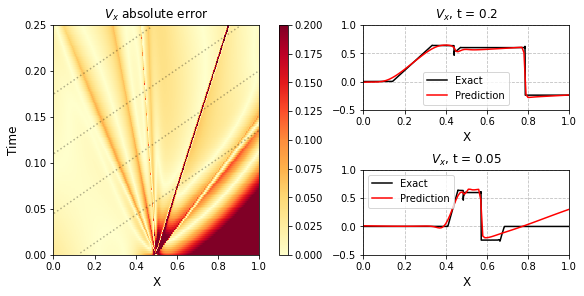

In [26]:
fig = plt.Figure(constrained_layout=True)
mosaic = """
AABB
AACC
"""
axd = fig.subplot_mosaic(mosaic)
img = axd['A'].pcolormesh(space,time,error_vx_abs.T, cmap=plt.cm.YlOrRd,vmin=0., vmax=0.2, shading='auto')
axd['A'].plot(sc_1[:,0], sc_1[:,1],color='k', ls=':',alpha=0.3)
axd['A'].plot(sc_2[:,0], sc_2[:,1],color='k', ls=':',alpha=0.3)
axd['A'].plot(sc_3[:,0], sc_3[:,1],color='k', ls=':',alpha=0.3)
axd['A'].plot(sc_4[:,0], sc_4[:,1],color='k', ls=':',alpha=0.3)
axd['A'].set_xlim(0.,1.)
axd['A'].set_ylim(0.,0.25)
axd['A'].set_xlabel("X",fontsize=12)
axd['A'].set_ylabel("Time",fontsize=12)
axd['A'].set_title("$V_x$ absolute error", fontsize=12)

axd['B'].plot(space,st_data[1,:,100],color='k',label="Exact")
i = np.where(sptim_lin[::nt_samp,1] >= 0.2)[0][0]
axd['B'].plot(sptim_lin[:nx_samp,0], pred_brio_lin[101*i:(i+1)*101,1],color='r', label='Prediction')
axd['B'].legend(loc='best')
axd['B'].set_xlim(0,1)
axd['B'].set_ylim(-0.5,1.)
axd['B'].set_xlabel("X",fontsize=12)
axd['B'].set_title("$V_x$, t = 0.2",fontsize=12)
axd['B'].grid(True,color='gray',ls='--',alpha=0.5)

axd['C'].plot(space,st_data[1,:,25],color='k',label="Exact")
i = np.where(sptim_lin[::nt_samp,1] >= 0.05)[0][0]
axd['C'].plot(sptim_lin[:nx_samp,0], pred_brio_lin[101*i:(i+1)*101,1],color='r', label='Prediction')
axd['C'].legend(loc='best')
axd['C'].set_xlim(0,1)
axd['C'].set_ylim(-0.5,1.)
axd['C'].set_xlabel("X",fontsize=12)
axd['C'].set_title("$V_x$, t = 0.05",fontsize=12)
axd['C'].grid(True,color='gray',ls='--',alpha=0.5)

fig.set_size_inches(8,4)
fig.colorbar(img, location='right',ax=axd['A'],fraction=0.01, aspect=50)
#fig.savefig("brio_mosaicvisc01_para_vel_noise1.png", dpi=300,facecolor='white',transparent=False)
fig